So i try two things difference the first one is to work with the combination model "CRF with Bi-LTSM" .And now try to train a pre-trained like "BERT, Roberta and DistlBert" model to do a benchmark and see the difference between this 3 and to create a comparatif table

In [ ]:
# import all the necessery library that i will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support
import torch

In [ ]:
from transformers import Trainer, TrainingArguments, BertTokenizerFast, BertForTokenClassification, DataCollatorForTokenClassification
from transformers import TrainerCallback
# Load the dataset
df = pd.read_csv('NER_iob.csv')

# Map IOB to numerical values
iob_mapping = {'O': 0, 'B': 1, 'I': 2}
df['IOB'] = df['IOB'].map(iob_mapping)

# Create a 'Sentence_ID' column assuming each sentence ends with a period (.)
df['Sentence_ID'] = (df['Token'] == '.').cumsum()

# Split the dataset
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Load another dataset (for adding tokens)
df_components = pd.read_csv('melted_data.csv')

# Extract the 'Component' column and drop NaN values
new_tokens = df_components['Component'].dropna().unique()  # Get unique components

# Clean tokens if necessary (e.g., replacing spaces with underscores)
new_tokens = [token.replace(" ", "_") for token in new_tokens if isinstance(token, str)]  # Ensure token is a string

# Load the pre-trained BERT tokenizer

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# Add new tokens (components) to the tokenizer
num_added_tokens = tokenizer.add_tokens(new_tokens)
print(f"Added {num_added_tokens} new tokens to the tokenizer.")

# Load the BERT model and resize embeddings to account for new tokens
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(iob_mapping))
model.resize_token_embeddings(len(tokenizer))

# Function to tokenize input and align labels
def tokenize_and_align_labels(grouped_sentences):
    tokenized_inputs = tokenizer(
        grouped_sentences['Token'].tolist(),
        is_split_into_words=True,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    labels = []
    word_ids = tokenized_inputs.word_ids(batch_index=0)

    current_labels = grouped_sentences['IOB'].tolist()
    label_ids = []
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)  # Ignored for special tokens
        elif word_idx != previous_word_idx:
            label_ids.append(current_labels[word_idx])  # Use label for the first subword
        else:
            label_ids.append(-100)  # Ignore subsequent subwords

        previous_word_idx = word_idx

    tokenized_inputs['labels'] = torch.tensor(label_ids, dtype=torch.long)
    return tokenized_inputs

# Group data by sentences
train_grouped = train_data.groupby("Sentence_ID")
test_grouped = test_data.groupby("Sentence_ID")

# Tokenize and align labels for the training and test sets
def process_grouped_data(grouped_data):
    tokenized_data = []
    for _, group in grouped_data:
        tokenized_inputs = tokenize_and_align_labels(group)
        tokenized_data.append(tokenized_inputs)
    return tokenized_data

train_encodings = process_grouped_data(train_grouped)
test_encodings = process_grouped_data(test_grouped)

# Create Dataset for Trainer
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: self.encodings[idx][key].squeeze(0) for key in self.encodings[idx]}

    def __len__(self):
        return len(self.encodings)

train_dataset = NERDataset(train_encodings)
eval_dataset = NERDataset(test_encodings)

# Define a data collator for dynamic padding
data_collator = DataCollatorForTokenClassification(tokenizer)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./BERTtest',
    num_train_epochs=30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./runs',  # Directory for storing logs
    logging_steps=10,  # Log every 10 steps
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_steps=1000,
    save_total_limit=2
)

# Define metrics computation
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=2)
    true_labels = labels

    # Flatten the predictions and labels
    true_labels_flat = true_labels.flatten()
    predictions_flat = predictions.flatten()

    # Filter out -100 (ignored tokens) from the evaluation
    mask = true_labels_flat != -100
    true_labels_flat = true_labels_flat[mask]
    predictions_flat = predictions_flat[mask]

    # Calculate metrics
    accuracy = accuracy_score(true_labels_flat, predictions_flat)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels_flat, predictions_flat, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

class MetricsLogger(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.validation_loss = []
        self.training_accuracy = []
        self.validation_accuracy = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.training_loss.append(logs['loss'])
            if 'eval_loss' in logs:
                self.validation_loss.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.validation_accuracy.append(logs['eval_accuracy'])
            if 'eval_accuracy' in logs and 'epoch' in logs:
                self.training_accuracy.append(logs['eval_accuracy'])

# Initialize the logger
metrics_logger = MetricsLogger()
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,  # Add the data collator for dynamic padding
    compute_metrics=compute_metrics,
    callbacks=[metrics_logger]
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Added 1240 new tokens to the tokenizer.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.372100,0.287806,0.903269,0.845553,0.903269,0.869454
2,0.255100,0.224465,0.922261,0.908088,0.922261,0.906835
3,0.165900,0.219643,0.918286,0.903082,0.918286,0.905240
4,0.102100,0.286584,0.889576,0.910126,0.889576,0.898007
5,0.052900,0.301869,0.918728,0.904821,0.918728,0.908412
6,0.044500,0.348115,0.897527,0.908354,0.897527,0.901453
7,0.028400,0.383294,0.909011,0.904995,0.909011,0.906786
8,0.026500,0.398800,0.894876,0.908976,0.894876,0.901155
9,0.023000,0.411146,0.901060,0.903242,0.901060,0.902123
10,0.008000,0.396958,0.911661,0.906627,0.911661,0.908865


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.372100,0.287806,0.903269,0.845553,0.903269,0.869454
2,0.255100,0.224465,0.922261,0.908088,0.922261,0.906835
3,0.165900,0.219643,0.918286,0.903082,0.918286,0.905240
4,0.102100,0.286584,0.889576,0.910126,0.889576,0.898007
5,0.052900,0.301869,0.918728,0.904821,0.918728,0.908412
6,0.044500,0.348115,0.897527,0.908354,0.897527,0.901453
7,0.028400,0.383294,0.909011,0.904995,0.909011,0.906786
8,0.026500,0.398800,0.894876,0.908976,0.894876,0.901155
9,0.023000,0.411146,0.901060,0.903242,0.901060,0.902123
10,0.008000,0.396958,0.911661,0.906627,0.911661,0.908865


TrainOutput(global_step=1140, training_loss=0.03980272495036683, metrics={'train_runtime': 7366.4945, 'train_samples_per_second': 2.415, 'train_steps_per_second': 0.155, 'total_flos': 251753025309390.0, 'train_loss': 0.03980272495036683, 'epoch': 30.0})

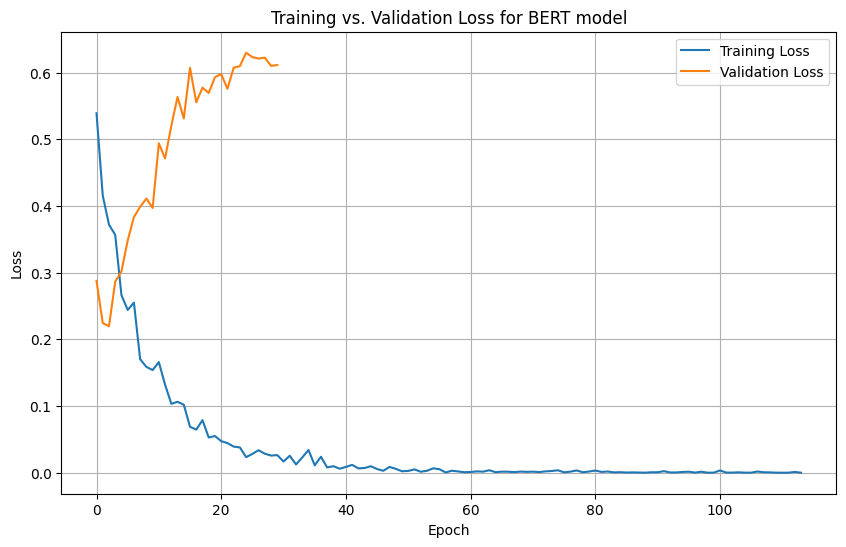

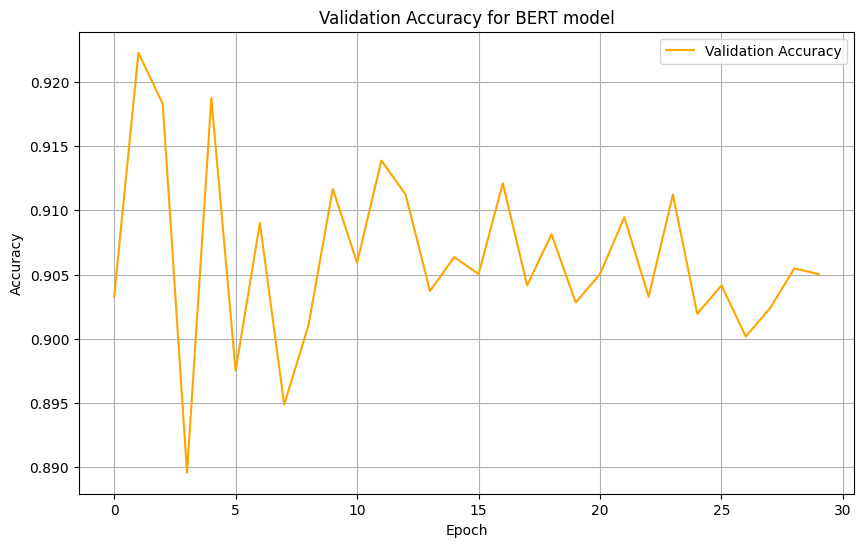

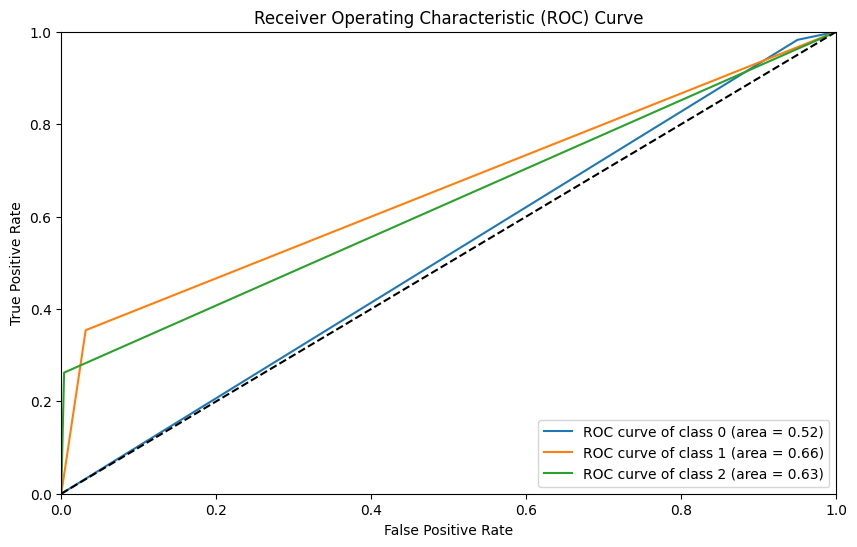

In [ ]:
def plot_loss_curve(training_loss, validation_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss for BERT model')
    plt.legend()
    plt.grid(True)
    plt.savefig('./loss_curve.png')
    plt.show()

# 2. Plot Validation Accuracy
def plot_accuracy_curve(validation_accuracy):
    plt.figure(figsize=(10, 6))
    plt.plot(validation_accuracy, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for BERT model')
    plt.legend()
    plt.grid(True)
    plt.savefig('./accuracy_curve.png')
    plt.show()

# 3. Compute and Plot ROC Curve
def plot_roc_curve(predictions, true_labels):
    # Binarize the output
    true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2])  # Assuming you have 3 classes
    predictions_bin = label_binarize(predictions, classes=[0, 1, 2])

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(true_labels_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(true_labels_bin.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig('./roc_curve.png')
    plt.show()

# 4. Plot Precision, Recall, and F1 Score
def plot_f1_curve(f1_vals):
    plt.figure(figsize=(10, 6))
    plt.plot(f1_vals, label='F1 Score', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score for BERT model')
    plt.legend()
    plt.grid(True)
    plt.savefig('./f1_curve.png')
    plt.show()

# Generate the plots
plot_loss_curve(metrics_logger.training_loss, metrics_logger.validation_loss)
plot_accuracy_curve(metrics_logger.validation_accuracy)
# You may want to gather predictions for the ROC curve after the training
predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=2)
# Call to plot ROC curve
plot_roc_curve(preds.flatten(), predictions.label_ids.flatten())

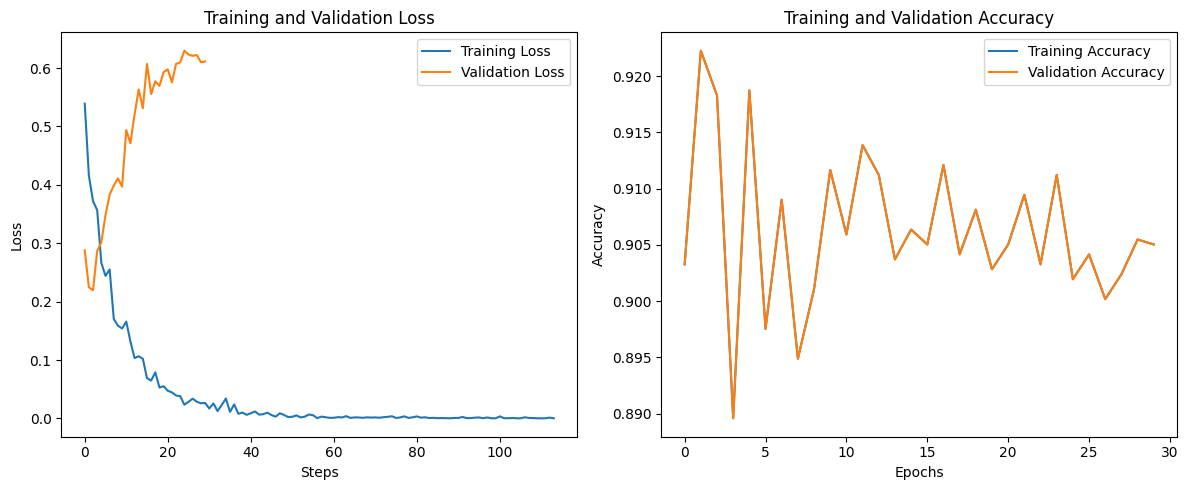

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics_logger.training_loss, label='Training Loss')
plt.plot(metrics_logger.validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics_logger.training_accuracy, label='Training Accuracy')
plt.plot(metrics_logger.validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

F1 Score: 0.9052395444027485


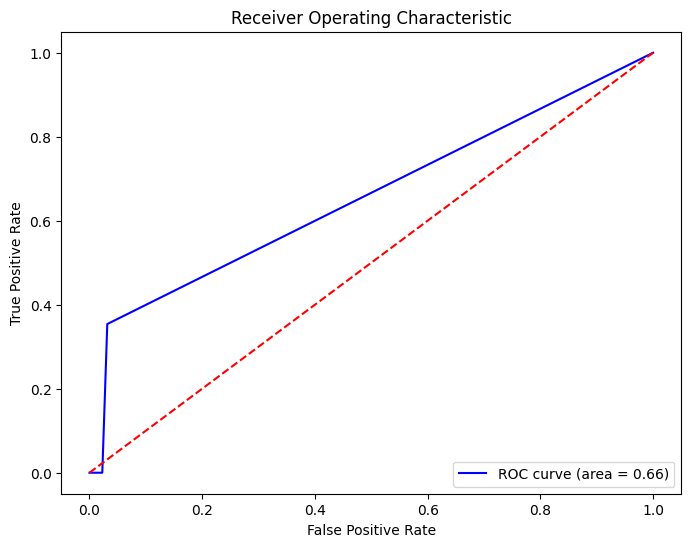

In [ ]:
from sklearn.metrics import f1_score, roc_curve, auc

# Get predictions
predictions, labels, _ = trainer.predict(eval_dataset)
predictions = np.argmax(predictions, axis=2)

# Flatten the predictions and labels
true_labels_flat = labels.flatten()
predictions_flat = predictions.flatten()

# Filter out -100 (ignored tokens)
mask = true_labels_flat != -100
true_labels_flat = true_labels_flat[mask]
predictions_flat = predictions_flat[mask]

# Compute F1 score
f1 = f1_score(true_labels_flat, predictions_flat, average='weighted')
print(f'F1 Score: {f1}')

# Compute ROC Curve
fpr, tpr, _ = roc_curve(true_labels_flat, predictions_flat, pos_label=1)  # Adjust pos_label as necessary
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

F1 Score: 0.9052395444027485


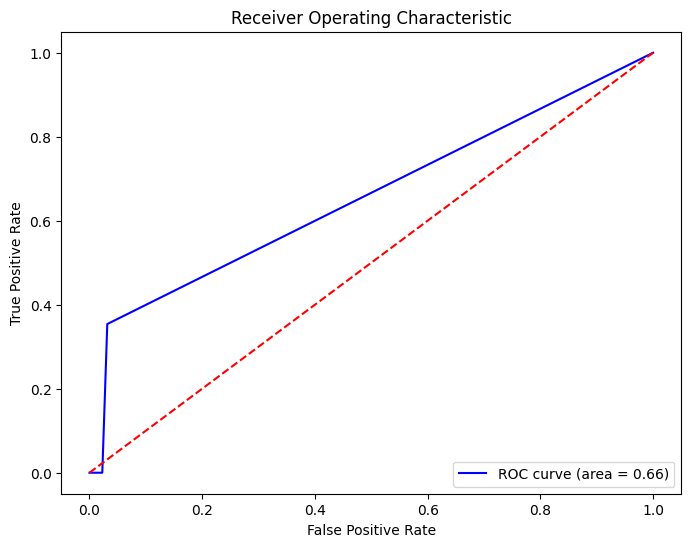

In [ ]:
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
predictions, labels, _ = trainer.predict(eval_dataset)
predictions = np.argmax(predictions, axis=2)

# Flatten the predictions and labels
true_labels_flat = labels.flatten()
predictions_flat = predictions.flatten()

# Filter out -100 (ignored tokens)
mask = true_labels_flat != -100
true_labels_flat = true_labels_flat[mask]
predictions_flat = predictions_flat[mask]

# Compute F1 score
f1 = f1_score(true_labels_flat, predictions_flat, average='weighted')
print(f'F1 Score: {f1}')

# Compute ROC Curve
# Note: ROC curve is generally used for binary classification.
# If you have more than two classes, you may want to use One-vs-Rest approach.
# Here we consider class '1' as positive (you can change this as needed).
# If it's a multiclass, you might want to compute a ROC for each class.
fpr, tpr, _ = roc_curve(true_labels_flat, predictions_flat, pos_label=1)  # Adjust pos_label as necessary
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


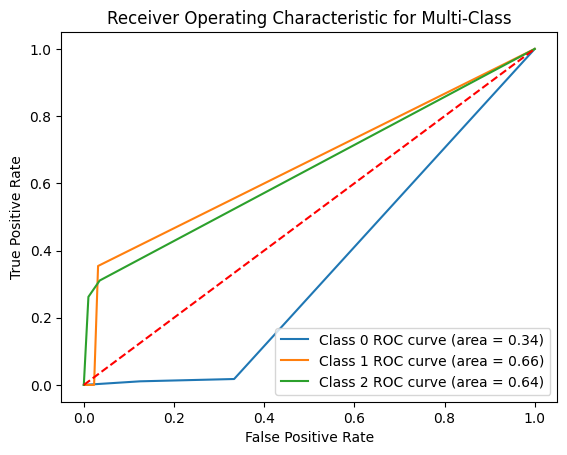

In [ ]:
from sklearn.metrics import roc_auc_score

# For multi-class, you might need to calculate the ROC AUC for each class
for class_label in np.unique(true_labels_flat):
    if class_label != -100:  # Exclude ignored tokens
        fpr, tpr, _ = roc_curve(true_labels_flat, predictions_flat, pos_label=class_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_label} ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random chance line
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# try to test this part of the model and after that i will use a now dataset for testing part
eval_results = trainer.evaluate()
print(f"Test Results: {eval_results}")


Test Results: {'eval_loss': 0.2196430116891861, 'eval_accuracy': 0.9182862190812721, 'eval_precision': 0.9030824335701603, 'eval_recall': 0.9182862190812721, 'eval_f1': 0.9052395444027485, 'eval_runtime': 24.9772, 'eval_samples_per_second': 23.101, 'eval_steps_per_second': 1.481, 'epoch': 30.0}


## Roberta Model

Now Roberta model to see the difference between the model and see if Roberta have a good prediction and good performance then BERT or not

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaF

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.306300,0.206077,0.918646,0.909273,0.918646,0.911408
2,0.152500,0.142215,0.946350,0.944442,0.946350,0.945145
3,0.093800,0.130710,0.956025,0.955774,0.956025,0.955879
4,0.060000,0.160658,0.948549,0.950489,0.948549,0.949357
5,0.040100,0.158296,0.957344,0.958171,0.957344,0.957685
6,0.028000,0.229803,0.955145,0.953204,0.955145,0.953583
7,0.030300,0.197022,0.957784,0.956153,0.957784,0.956569
8,0.010800,0.268351,0.959543,0.958809,0.959543,0.959117
9,0.008400,0.251775,0.962181,0.960856,0.962181,0.961163
10,0.007100,0.257862,0.962181,0.961434,0.962181,0.961734



***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./Robertatest/checkpoint-30
Configuration saved in ./Robertatest/checkpoint-30/config.json
Model weights saved in ./Robertatest/checkpoint-30/model.safetensors

***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./Robertatest/checkpoint-60
Configuration saved in ./Robertatest/checkpoint-60/config.json
Model weights saved in ./Robertatest/checkpoint-60/model.safetensors

***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./Robertatest/checkpoint-90
Configuration saved in ./Robertatest/checkpoint-90/config.json
Model weights saved in ./Robertatest/checkpoint-90/model.safetensors

***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./Robertatest/checkpoint-120
Configuration saved in ./Robertatest/checkpoint-120/config.json
Model weights saved in ./Robertatest/ch

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.306300,0.206077,0.918646,0.909273,0.918646,0.911408
2,0.152500,0.142215,0.946350,0.944442,0.946350,0.945145
3,0.093800,0.130710,0.956025,0.955774,0.956025,0.955879
4,0.060000,0.160658,0.948549,0.950489,0.948549,0.949357
5,0.040100,0.158296,0.957344,0.958171,0.957344,0.957685
6,0.028000,0.229803,0.955145,0.953204,0.955145,0.953583
7,0.030300,0.197022,0.957784,0.956153,0.957784,0.956569
8,0.010800,0.268351,0.959543,0.958809,0.959543,0.959117
9,0.008400,0.251775,0.962181,0.960856,0.962181,0.961163
10,0.007100,0.257862,0.962181,0.961434,0.962181,0.961734



***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./Robertatest/checkpoint-810
Configuration saved in ./Robertatest/checkpoint-810/config.json
Model weights saved in ./Robertatest/checkpoint-810/model.safetensors

***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./Robertatest/checkpoint-840
Configuration saved in ./Robertatest/checkpoint-840/config.json
Model weights saved in ./Robertatest/checkpoint-840/model.safetensors

***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./Robertatest/checkpoint-870
Configuration saved in ./Robertatest/checkpoint-870/config.json
Model weights saved in ./Robertatest/checkpoint-870/model.safetensors
Saving model checkpoint to ./Robertatest/checkpoint-900
Configuration saved in ./Robertatest/checkpoint-900/config.json
Model weights saved in ./Robertatest/checkpoint-900/model.safetensors

***** Running Evaluation ****

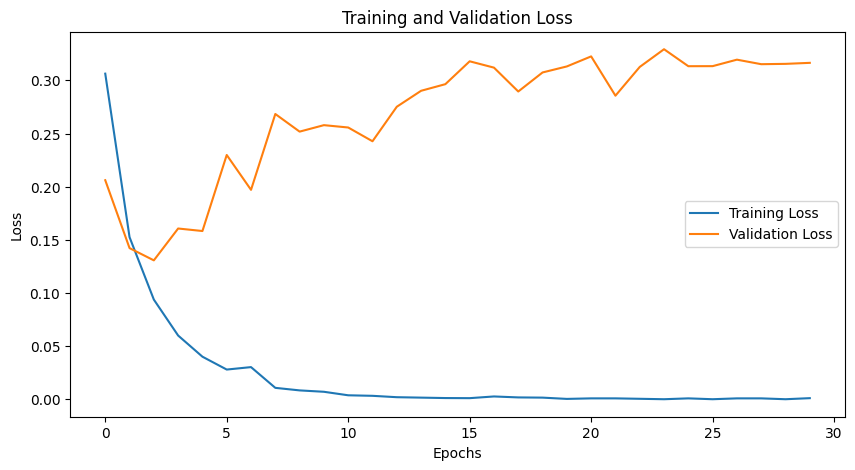

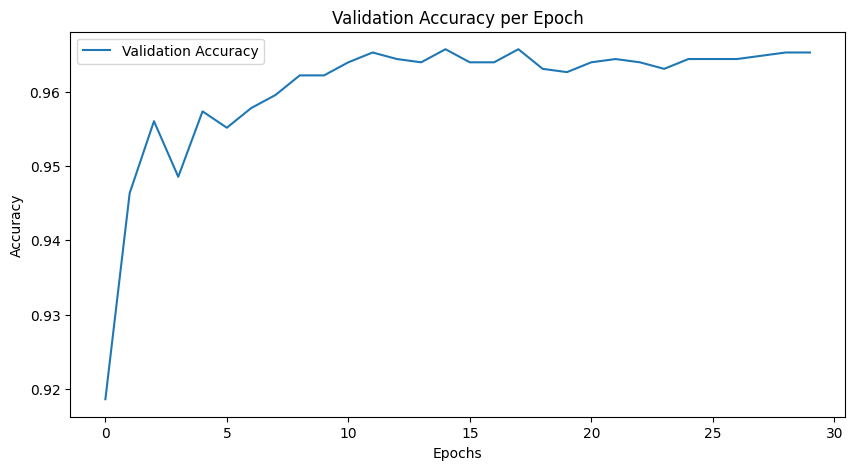

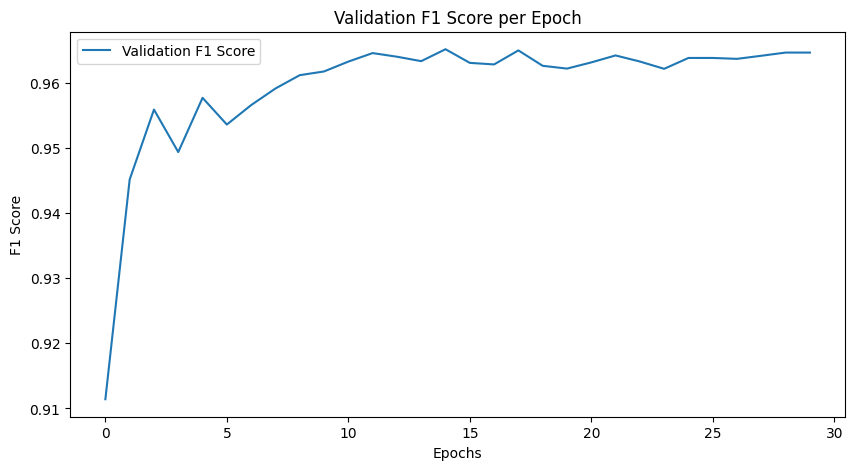

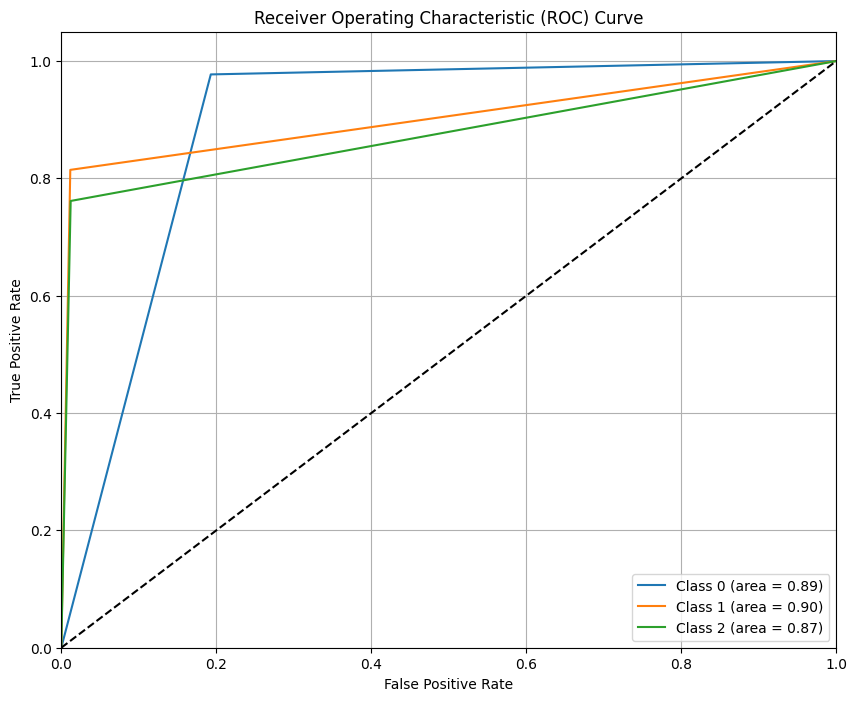

In [ ]:
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification, TrainerCallback
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load the data
df = pd.read_csv('NER_iob.csv')

# Map IOB to numerical values
iob_mapping = {'O': 0, 'B': 1, 'I': 2}
df['IOB'] = df['IOB'].map(iob_mapping)

# Create a 'Sentence_ID' column assuming each sentence ends with a period (.)
df['Sentence_ID'] = (df['Token'] == '.').cumsum()

# Group by 'Sentence_ID' to get tokens and labels for each sentence
grouped = df.groupby('Sentence_ID').agg({'Token': list, 'IOB': list}).reset_index()

# Split the dataset
train_data, test_data = train_test_split(grouped, test_size=0.2, random_state=42)

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True)

# Function to tokenize sentences and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['Token'], is_split_into_words=True, padding=True, truncation=True)
    labels = []
    word_ids = tokenized_inputs.word_ids()  # Map tokens to their respective word in the sentence

    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(examples['IOB'][word_idx])
        else:
            label_ids.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

# Define a custom dataset class for token classification
class NERDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

# Prepare the datasets
train_encodings = [tokenize_and_align_labels(row) for _, row in train_data.iterrows()]
test_encodings = [tokenize_and_align_labels(row) for _, row in test_data.iterrows()]

# Convert the encodings into a dataset
train_dataset = NERDataset({key: [dic[key] for dic in train_encodings] for key in train_encodings[0].keys()})
test_dataset = NERDataset({key: [dic[key] for dic in test_encodings] for key in test_encodings[0].keys()})

# Load the RoBERTa model
model = RobertaForTokenClassification.from_pretrained('roberta-base', num_labels=len(iob_mapping))

# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./Robertatest',
    num_train_epochs=30,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",  # Log metrics after each epoch
    logging_strategy="epoch",     # Log loss after each epoch
    save_strategy="epoch",        # Save model at each epoch
    load_best_model_at_end=True,
    logging_dir='./logs',
    log_level='info',
)

# Define metrics computation
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=2)
    true_labels = labels

    # Flatten the predictions and labels
    true_labels_flat = true_labels.flatten()
    predictions_flat = predictions.flatten()

    # Filter out -100 (ignored tokens) from the evaluation
    mask = true_labels_flat != -100
    true_labels_flat = true_labels_flat[mask]
    predictions_flat = predictions_flat[mask]

    # Calculate metrics
    accuracy = accuracy_score(true_labels_flat, predictions_flat)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels_flat, predictions_flat, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initialize lists to store metrics
training_loss_list = []
eval_loss_list = []
eval_accuracy_list = []
eval_f1_list = []

# Define a custom callback to store the metrics
class MetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            training_loss_list.append(logs['loss'])
        if 'eval_loss' in logs:
            eval_loss_list.append(logs['eval_loss'])
        if 'eval_accuracy' in logs:
            eval_accuracy_list.append(logs['eval_accuracy'])
        if 'eval_f1' in logs:
            eval_f1_list.append(logs['eval_f1'])

# Attach the callback to the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[MetricsCallback()]
)

# Train the model
trainer.train()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss_list, label="Training Loss")
plt.plot(eval_loss_list, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(eval_accuracy_list, label="Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot the F1 score per epoch
plt.figure(figsize=(10, 5))
plt.plot(eval_f1_list, label="Validation F1 Score")
plt.title("Validation F1 Score per Epoch")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# Get true labels and predictions for the test set
true_labels_flat = []
predictions_flat = []

for batch in test_dataset:
    inputs = {k: v.unsqueeze(0).to(trainer.model.device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = np.argmax(logits.detach().cpu().numpy(), axis=2)
    true_labels_flat.append(batch['labels'].detach().cpu().numpy().flatten())
    predictions_flat.append(predictions.flatten())

true_labels_flat = np.concatenate(true_labels_flat)
predictions_flat = np.concatenate(predictions_flat)

# Filter out -100 labels (special tokens)
mask = true_labels_flat != -100
true_labels_flat = true_labels_flat[mask]
predictions_flat = predictions_flat[mask]

# Binarize labels for ROC curve (multi-class, one-vs-rest)
y_test_binarized = label_binarize(true_labels_flat, classes=[0, 1, 2])
y_pred_binarized = label_binarize(predictions_flat, classes=[0, 1, 2])

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



## Training DistilBert Model  

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.2",
  "vocab_size": 30522
}

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False`

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not ini

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.333700,0.206877,0.905013,0.888858,0.905013,0.885489
2,0.147600,0.135398,0.941073,0.944561,0.941073,0.942523
3,0.073300,0.126869,0.954705,0.957631,0.954705,0.955819
4,0.036900,0.150513,0.953386,0.960296,0.953386,0.955608
5,0.023600,0.151405,0.960862,0.959941,0.960862,0.960240
6,0.010900,0.191643,0.955145,0.959757,0.955145,0.956745
7,0.007100,0.174854,0.964820,0.964425,0.964820,0.964447
8,0.006000,0.184840,0.962621,0.963453,0.962621,0.962967
9,0.003500,0.195271,0.964820,0.963936,0.964820,0.964189
10,0.002800,0.191551,0.960862,0.960994,0.960862,0.960919



***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./DistilBertTest/checkpoint-30
Configuration saved in ./DistilBertTest/checkpoint-30/config.json
Model weights saved in ./DistilBertTest/checkpoint-30/model.safetensors

***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./DistilBertTest/checkpoint-60
Configuration saved in ./DistilBertTest/checkpoint-60/config.json
Model weights saved in ./DistilBertTest/checkpoint-60/model.safetensors

***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./DistilBertTest/checkpoint-90
Configuration saved in ./DistilBertTest/checkpoint-90/config.json
Model weights saved in ./DistilBertTest/checkpoint-90/model.safetensors

***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./DistilBertTest/checkpoint-120
Configuration saved in ./DistilBertTest/checkpoint-120/config.json
Model 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.333700,0.206877,0.905013,0.888858,0.905013,0.885489
2,0.147600,0.135398,0.941073,0.944561,0.941073,0.942523
3,0.073300,0.126869,0.954705,0.957631,0.954705,0.955819
4,0.036900,0.150513,0.953386,0.960296,0.953386,0.955608
5,0.023600,0.151405,0.960862,0.959941,0.960862,0.960240
6,0.010900,0.191643,0.955145,0.959757,0.955145,0.956745
7,0.007100,0.174854,0.964820,0.964425,0.964820,0.964447
8,0.006000,0.184840,0.962621,0.963453,0.962621,0.962967
9,0.003500,0.195271,0.964820,0.963936,0.964820,0.964189
10,0.002800,0.191551,0.960862,0.960994,0.960862,0.960919


Saving model checkpoint to ./DistilBertTest/checkpoint-900
Configuration saved in ./DistilBertTest/checkpoint-900/config.json
Model weights saved in ./DistilBertTest/checkpoint-900/model.safetensors

***** Running Evaluation *****
  Num examples = 119
  Batch size = 8
Saving model checkpoint to ./DistilBertTest/checkpoint-900
Configuration saved in ./DistilBertTest/checkpoint-900/config.json
Model weights saved in ./DistilBertTest/checkpoint-900/model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./DistilBertTest/checkpoint-90 (score: 0.1268690675497055).


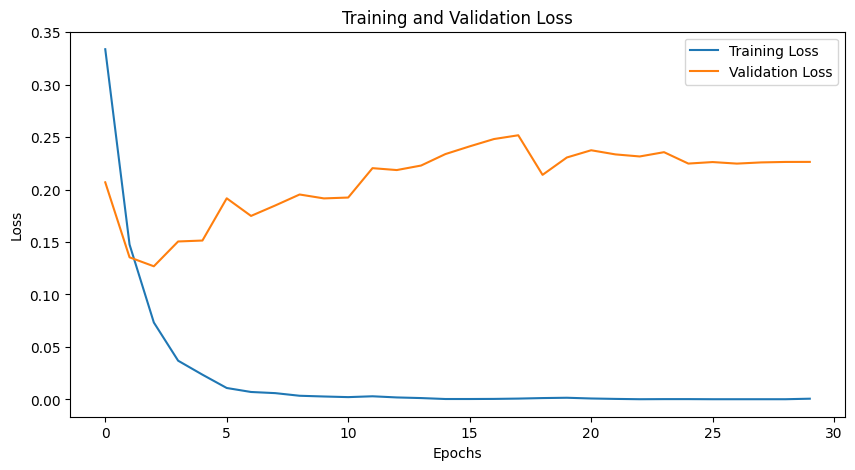

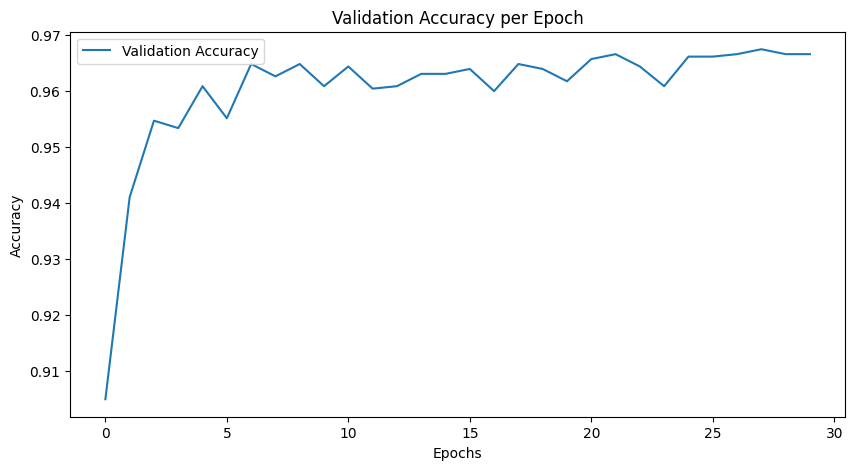

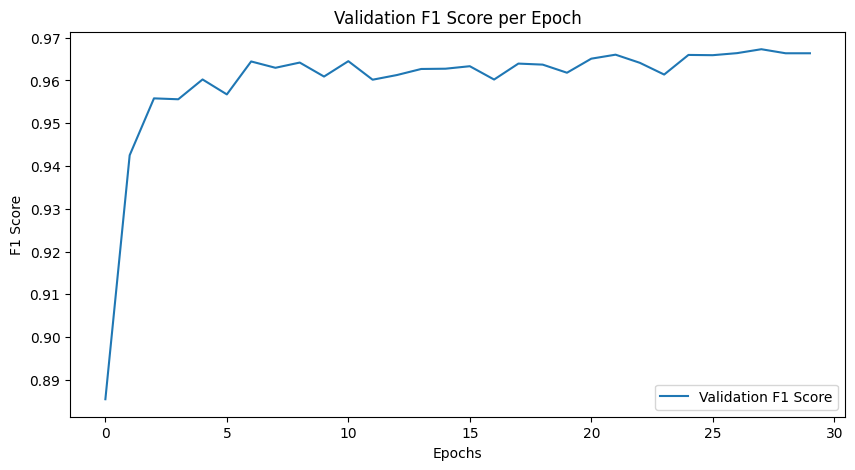

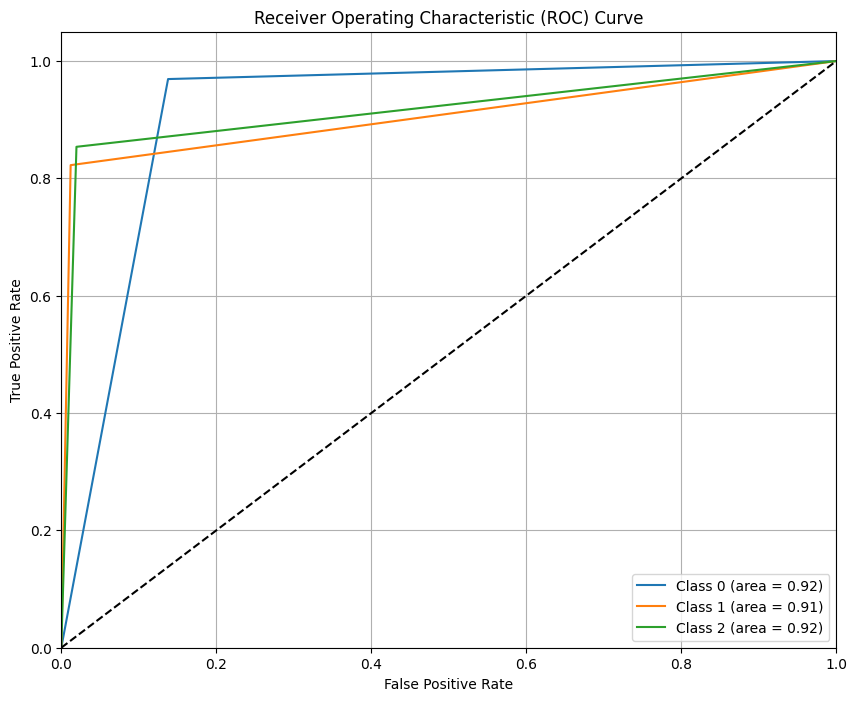

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification, TrainerCallback
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load the data
df = pd.read_csv('NER_iob.csv')

# Map IOB to numerical values
iob_mapping = {'O': 0, 'B': 1, 'I': 2}
df['IOB'] = df['IOB'].map(iob_mapping)

# Create a 'Sentence_ID' column assuming each sentence ends with a period (.)
df['Sentence_ID'] = (df['Token'] == '.').cumsum()

# Group by 'Sentence_ID' to get tokens and labels for each sentence
grouped = df.groupby('Sentence_ID').agg({'Token': list, 'IOB': list}).reset_index()

# Split the dataset
train_data, test_data = train_test_split(grouped, test_size=0.2, random_state=42)

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Function to tokenize sentences and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['Token'], is_split_into_words=True, padding=True, truncation=True)
    labels = []
    word_ids = tokenized_inputs.word_ids()  # Map tokens to their respective word in the sentence

    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(examples['IOB'][word_idx])
        else:
            label_ids.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

# Define a custom dataset class for token classification
class NERDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

# Prepare the datasets
train_encodings = [tokenize_and_align_labels(row) for _, row in train_data.iterrows()]
test_encodings = [tokenize_and_align_labels(row) for _, row in test_data.iterrows()]

# Convert the encodings into a dataset
train_dataset = NERDataset({key: [dic[key] for dic in train_encodings] for key in train_encodings[0].keys()})
test_dataset = NERDataset({key: [dic[key] for dic in test_encodings] for key in test_encodings[0].keys()})

# Load the DistilBERT model
model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(iob_mapping))

# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./DistilBertTest',
    num_train_epochs=30,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",  # Log metrics after each epoch
    logging_strategy="epoch",     # Log loss after each epoch
    save_strategy="epoch",        # Save model at each epoch
    load_best_model_at_end=True,
    logging_dir='./logs',
    log_level='info',
)

# Define metrics computation
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=2)
    true_labels = labels

    # Flatten the predictions and labels
    true_labels_flat = true_labels.flatten()
    predictions_flat = predictions.flatten()

    # Filter out -100 (ignored tokens) from the evaluation
    mask = true_labels_flat != -100
    true_labels_flat = true_labels_flat[mask]
    predictions_flat = predictions_flat[mask]

    # Calculate metrics
    accuracy = accuracy_score(true_labels_flat, predictions_flat)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels_flat, predictions_flat, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initialize lists to store metrics
training_loss_list = []
eval_loss_list = []
eval_accuracy_list = []
eval_f1_list = []

# Define a custom callback to store the metrics
class MetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            training_loss_list.append(logs['loss'])
        if 'eval_loss' in logs:
            eval_loss_list.append(logs['eval_loss'])
        if 'eval_accuracy' in logs:
            eval_accuracy_list.append(logs['eval_accuracy'])
        if 'eval_f1' in logs:
            eval_f1_list.append(logs['eval_f1'])

# Attach the callback to the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[MetricsCallback()]
)

# Train the model
trainer.train()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss_list, label="Training Loss")
plt.plot(eval_loss_list, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(eval_accuracy_list, label="Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot the F1 score per epoch
plt.figure(figsize=(10, 5))
plt.plot(eval_f1_list, label="Validation F1 Score")
plt.title("Validation F1 Score per Epoch")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# Get true labels and predictions for the test set
true_labels_flat = []
predictions_flat = []

for batch in test_dataset:
    inputs = {k: v.unsqueeze(0).to(trainer.model.device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = np.argmax(logits.detach().cpu().numpy(), axis=2)
    true_labels_flat.append(batch['labels'].detach().cpu().numpy().flatten())
    predictions_flat.append(predictions.flatten())

true_labels_flat = np.concatenate(true_labels_flat)
predictions_flat = np.concatenate(predictions_flat)

# Filter out -100 labels (special tokens)
mask = true_labels_flat != -100
true_labels_flat = true_labels_flat[mask]
predictions_flat = predictions_flat[mask]

# Binarize labels for ROC curve (multi-class, one-vs-rest)
y_test_binarized = label_binarize(true_labels_flat, classes=[0, 1, 2])
y_pred_binarized = label_binarize(predictions_flat, classes=[0, 1, 2])

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# try to test this part of the model and after that i will use a now dataset for testing part
eval_results = trainer.evaluate()
print(f"Test Results: {eval_results}")



***** Running Evaluation *****
  Num examples = 119
  Batch size = 8


Test Results: {'eval_loss': 0.1268690675497055, 'eval_accuracy': 0.9547053649956024, 'eval_precision': 0.9576306358538881, 'eval_recall': 0.9547053649956024, 'eval_f1': 0.9558194531616437, 'eval_runtime': 13.539, 'eval_samples_per_second': 8.789, 'eval_steps_per_second': 1.108, 'epoch': 30.0}
